In [1]:
import exsample
import importlib
importlib.reload(exsample)
import exsample.exsample_benchmark
import exsample.exsample_sampler
importlib.reload(exsample.exsample_sampler)
importlib.reload(exsample.exsample_benchmark)
import matplotlib
import matplotlib.pyplot as plt
from exsample.exsample_benchmark import *
from exsample.exsample_sampler import *
importlib.reload(exsample.exsample_sampler)
importlib.reload(exsample.exsample_benchmark)
from exsample.exsample_sampler import *
from exsample.exsample_benchmark import *

In [2]:
root = '/home/gridsan/omoll/data/exsample_data/'
#root = '/big_fast_drive/orm/exsample_data/'

dsm = [  DatasetMetadata(name='dashcam_unified_ng',
                    boxpath=f'{root}/dashcam_unified_ng.track_ids.clean.parquet',
                    track_id='tid',
                    frame_id='frame_idx',
                    video_len=1164226,
                    category='category',
                    categories=[
                        'person',
                        'bicycle',
                        'bus',
                        'truck',
                        'traffic light',
                        'fire hydrant',
                        'stop sign'],
                    default_chunks=(f'{root}/dash_metadata_by_frame.parquet', 'chunk_id'),
                         # this chunk id already is split by file and then 30 minutes
                    logitpath=f'{root}/dashcam_logits_secon_version.parquet',
                    logitsplit='subset'),
    DatasetMetadata(name='bdd1k',
                    boxpath=f'{root}/bdd1k.track_ids.clean.parquet',
                    track_id='tid',
                    frame_id='frame_idx',
                    video_len=389662,  # 1/3 frames of 1k ~40 second clips.
                    category='category',
                    categories=['person',
                                'rider',
                                'bus',
                                'truck',
                                'bike',
                                'motor',
                                'traffic light',
                                'traffic sign',],
                    default_chunks=(f'{root}/bdd_metadata_by_frame.parquet', 'clip_id'),
                    logitpath=f'{root}/bdd_logits_v0.parquet',
                    logitsplit='subset'),
        DatasetMetadata(name='bdd_mot_labels',
                boxpath=f'{root}/bdd_mot_labels.parquet',
                track_id='id',
                frame_id='frame_idx',
                video_len=None,
                category='category',
                categories=['car','pedestrian','truck','bicycle','rider','bus','motorcycle'],
                default_chunks=(f'{root}/bdd_mot_frames.parquet','video_name'),
                logitpath=None,
                logitsplit=None),
    DatasetMetadata(name='jackson-town-square',
                        boxpath=f'{root}/jackson-town-square_boxes_tids_filtered.parquet',
                        track_id='tid', frame_id='frame_idx', category='category',
                        categories=['car', 'person', 'truck', 'bus', 'dog', 'motorcycle'],
                        video_len=None, default_chunks=None, 
                        logitpath=None, logitsplit=None),
   DatasetMetadata(name='archie-day',
                    boxpath=f'{root}/archie-day_boxes_tids_filtered.parquet',
                    track_id='tid', frame_id='frame_idx', category='category',
                    categories=['car', 'bicycle', 'person', 'motorcycle', 'truck', 'bus'], 
                    video_len=None, default_chunks=None, 
                    logitpath=None, logitsplit=None),
   DatasetMetadata(name='amsterdam',
                    boxpath=f'{root}/amsterdam_boxes_tids_filtered.parquet',
                    track_id='tid', frame_id='frame_idx', category='category',
                    categories=['boat', 'car', 'person', 'bicycle', 'truck', 'motorcycle', 'dog'],                        video_len=None, default_chunks=None, 
                    logitpath=None, logitsplit=None)
]

In [3]:
bms = []
for m in dsm:
    bms.append(BenchmarkDataset(m))

In [5]:
# see original sigmod_eval_all_datasets
df = pd.read_parquet('./data/sample_results.parquet')

In [6]:
def method_rename(m):
    mapping = {'random_nosplit_10_None':'random', 
               'random+_nosplit_10_None':'random+',
               'random+_default_10_StatScorer_stat_gt_exp_model_ts_gt_ts':'this work'}
    return mapping[m]

In [8]:
df = df.assign(method=df.method.map(method_rename))
df = df.assign(task=make_composite(df, ['dataset', 'object_class']))

In [71]:
def savings_at(records, task_keys, method_keys,
               fixed_metric,
               fixed_metric_level,
               measured_metric,
               quantiles=[.1, .5, .9],
               experiment_key='experiment_id', reference_method='None_random_nosplit'):
    assert fixed_metric in ['instance_f']
    assert measured_metric in ['nf']

    pred = records[fixed_metric] >= fixed_metric_level
    records = records.assign(metric=records[measured_metric])

    sc = records[pred].groupby(task_keys + method_keys + ['experiment_id'],
                               as_index=False).metric.min()

    def quantile_agg(q):
        return lambda x: np.quantile(x, q)

    msc = sc.groupby(task_keys + method_keys).agg(lower=pd.NamedAgg('metric', quantile_agg(quantiles[0])),
                                                  metric=pd.NamedAgg('metric', quantile_agg(quantiles[1])),
                                                  upper=pd.NamedAgg('metric', quantile_agg(quantiles[2]))
                                                  )
    msc = msc.reset_index()
    gps = []
    for (ks, gp) in msc.groupby(task_keys):
        row = (gp[method_keys] == reference_method).all(axis=1)
        assert row.sum() <= 1, 'must have atmost one reference row per group'
        if row.sum() > 0:
            ref = gp[row].metric.iloc[0]
        else:
            ref = np.nan

        other = gp.metric
        gp = gp.assign(ratio=(ref + 1) / (other + 1))
        gp = gp.assign(ref=ref)
        gps.append(gp)

    return pd.concat(gps, ignore_index=True)


In [ ]:
svgs = []
# levels = [np.arange(1,50,1),
#           np.arange(50,500,step=5),
#           np.arange(500,1000,step=10),
#          ]
# all_levels = sum(map(list,levels),[])
all_levels = [.1, .5, .9]

for level in all_levels:    
    svgs.append(savings_at(df, fixed_metric='instance_f',
                           fixed_metric_level=level,
                           measured_metric='nf',
                           task_keys=['task', 'dataset', 'object_class'], 
                           method_keys=['method'],
                           quantiles=[.25,.5,.75],
                           reference_method=('random')).assign(level=level))
svgs = pd.concat(svgs, ignore_index=True)
#svgs = svgs.assign(ratio=svgs.ratio)


In [165]:
svgs = svgs[~svgs.dataset.isin(['bdd_mot_labels'])]
            #svgs.groupby(['dataset', 'object_class'])

In [88]:
from plotnine import *

In [166]:
svgs_this = svgs[(svgs.method == 'this work')]

In [167]:
svgs_worder = svgs_this.groupby('level').apply(lambda gp : gp.sort_values('ratio', ascending=False).assign(order_ref=np.arange(gp.shape[0])))

In [168]:
svgs_worder[svgs_worder.level == .5]

task      dataset   object_class  \
level                                                                     
0.5   209        dashcam_unified_ng_bicycle      dashcam        bicycle   
      218         dashcam_unified_ng_person      dashcam         person   
      224  dashcam_unified_ng_traffic light      dashcam  traffic light   
      215   dashcam_unified_ng_fire hydrant      dashcam   fire hydrant   
      173                      bdd1k_person          bdd         person   
      242        jackson-town-square_person  town-square         person   
      164                        bdd1k_bike          bdd           bike   
      170                       bdd1k_motor          bdd          motor   
      221      dashcam_unified_ng_stop sign      dashcam      stop sign   
      212            dashcam_unified_ng_bus      dashcam            bus   
      176                       bdd1k_rider          bdd          rider   
      167                         bdd1k_bus          bdd            bus   
      185                       bdd1k_truck          bdd          truck   
      137              amsterdam_motorcycle    amsterdam     motorcycle   
      233           jackson-town-square_car  town-square            car   
      179               bdd1k_traffic light          bdd  traffic light   
      134                     amsterdam_dog    amsterdam            dog   
      245         jackson-town-square_truck  town-square          truck   
      227          dashcam_unified_ng_truck      dashcam          truck   
      125                 amsterdam_bicycle    amsterdam        bicycle   
      182                bdd1k_traffic sign          bdd   traffic sign   
      236           jackson-town-square_dog  town-square            dog   
      140                  amsterdam_person    amsterdam         person   
      143                   amsterdam_truck    amsterdam          truck   
      131                     amsterdam_car    amsterdam            car   
      158                 archie-day_person   archie-day         person   
      155             archie-day_motorcycle   archie-day     motorcycle   
      146                archie-day_bicycle   archie-day        bicycle   
      161                  archie-day_truck   archie-day          truck   
      239    jackson-town-square_motorcycle  town-square     motorcycle   
      230           jackson-town-square_bus  town-square            bus   
      152                    archie-day_car   archie-day            car   
      149                    archie-day_bus   archie-day            bus   
      128                    amsterdam_boat    amsterdam           boat   

              method     lower    metric     upper     ratio       ref  level  \
level                                                                           
0.5   209  this work    6300.0    7460.0    7895.0  6.968369   51990.0    0.5   
      218  this work    5390.0    5520.0    5790.0  6.826843   37690.0    0.5   
      224  this work    8535.0    8660.0    8820.0  5.549128   48060.0    0.5   
      215  this work   17875.0   18270.0   19535.0  3.842209   70200.0    0.5   
      173  this work    7760.0    7870.0    7975.0  3.732817   29380.0    0.5   
      242  this work    2095.0    2170.0    2230.0  3.321511    7210.0    0.5   
      164  this work   10345.0   10600.0   11010.0  2.729082   28930.0    0.5   
      170  this work    9700.0   10460.0   11275.0  2.648026   27700.0    0.5   
      221  this work   22995.0   25200.0   25645.0  2.445181   61620.0    0.5   
      212  this work   28115.0   29420.0   31085.0  2.270181   66790.0    0.5   
      176  this work   12055.0   12320.0   12780.0  2.253957   27770.0    0.5   
      167  this work   12625.0   12780.0   12845.0  2.044519   26130.0    0.5   
      185  this work   12370.0   12730.0   12895.0  2.029770   25840.0    0.5   
      137  this work   27060.0   28940.0   31695.0  2.026917   58660.0    0.5   
      233  this work    2790.0    2800.0  

In [170]:
svgs_worder = svgs_worder.reset_index(drop=True)

In [171]:
plot_name = svgs_worder.dataset.map(lambda x : {'jackson-town-square':'town-square', 
                                    'dashcam_unified_ng':'dashcam', 'bdd1k':'bdd'}.get(x,x))
svgs_worder = svgs_worder.assign(dataset=plot_name)

In [177]:
import scipy

In [178]:
from scipy.stats import gmean

In [181]:
svgs_worder.groupby('method').ratio.agg(gmean)

method
this work    1.881305
Name: ratio, dtype: float64

In [183]:
svgs_worder.ratio.quantile([.1, .5, .9])

0.1    1.189272
0.5    1.692983
0.9    3.724493
Name: ratio, dtype: float64

In [179]:
gmean(svgs_worder.ratio)

1.8813048369781296

In [174]:
rcplot = (ggplot(data=svgs_worder[svgs_worder.method.isin(['this work'])]) # archie day
  + geom_col(aes(x='order_ref', y='ratio', fill='dataset'), alpha=.7)
  + facet_grid(facets=('level', '.'), scales='free_y')
  + scale_x_continuous(name='', )
  + theme(figure_size=(3.2*2.2,3.3*2.2), 
          axis_text_x=element_blank(), 
          axis_ticks=element_blank(),
          legend_position='top',
          legend_box_margin=0,
          axis_ticks_minor=element_blank(),
          axis_text_y=element_text(size=11),
          legend_text=element_text(size=11),
          subplots_adjust={'wspace': 0.25})
 + scale_y_log10(name='savings ratio (log)', breaks=[1., 1.5, 2., 3., 4., 5., 6.])
 + scale_fill_discrete(name='')
#  + annotate('hline', yintercept=.9)
 + geom_text(aes(label='object_class', x='order_ref', y=1.05), angle=90, va='bottom')
)

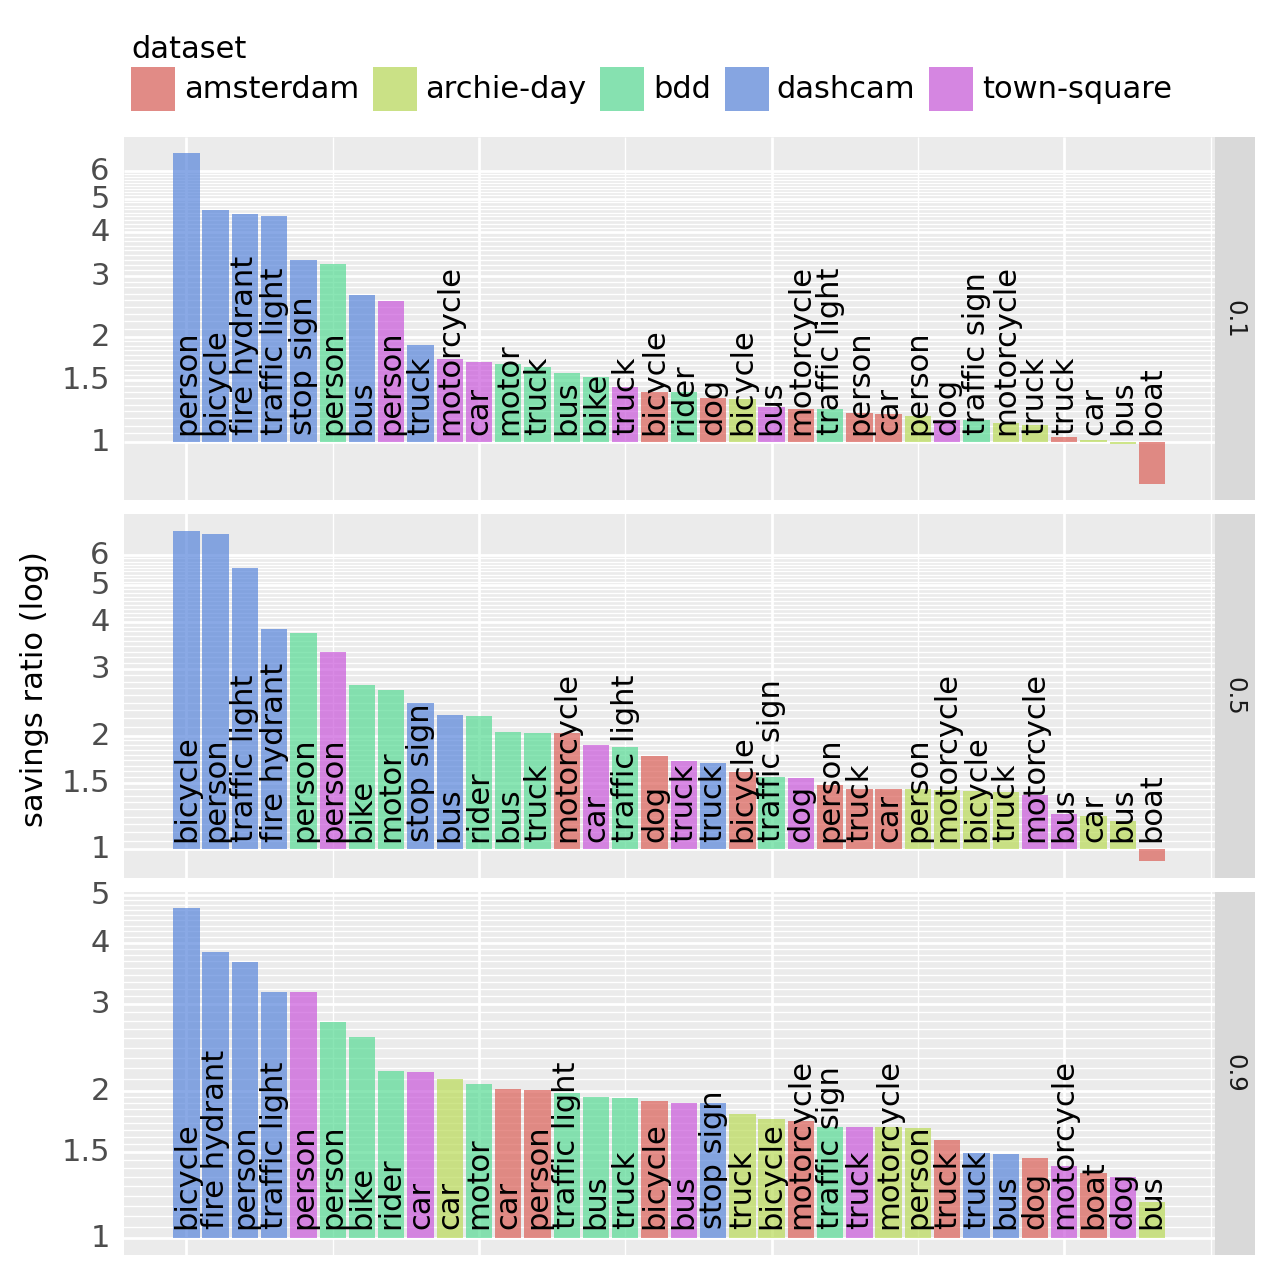

<ggplot: (8764294542948)>

In [175]:
rcplot

In [176]:
rcplot.save('./assets/ratioplot.pdf')

/home/gridsan/omoll/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 7.040000000000001 x 7.26 in image.
/home/gridsan/omoll/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./assets/ratioplot.pdf


In [34]:
from plotnine import *
xmin=10.
pdf = svgs #[svgs.method.isin(['random', 'this work', 'random1_dummy_dummy'])]
pdf = pdf.assign(lower=pdf.lower.round(), 
                metric=pdf.metric.round(),
                upper=pdf.upper.round())
simplot = (ggplot(pdf)
# + geom_ribbon(aes(y='level', xmin='lower',xmax='upper',fill='method'), alpha=.2, color=None)
 + geom_line(aes(x='metric', y='level', color='method'))
#  + geom_line(aes(x='nf', y='ni', color='method'),
#              data=dfmodel.dropna(axis=0), 
#              linetype='--', alpha=1.)
 #+ geom_point(aes(x='level', y='metric', color='method'))
 #+ geom_segment(aes(x='ref', xend='metric', y='level', yend='level'), data=rel.assign(ref=rel.ref.clip(xmin+.1)))
#  + geom_text(aes(x='mid', y='level', label='ratio'), format_string='{:2.2g}x',
#              ha='center', va='bottom', data=rel)
+ facet_wrap(facets=['task'], scales='free', ncol=5)
# + facet_grid(facets=['dur_coeff','skew'], scales='free', labeller=lab)
+ theme(figure_size=(5*2.3,9*1.75), 
         subplots_adjust={'wspace': 0.25, 'hspace':.25}, )
+ scale_x_log10(name='number of frames sampled')
           #(out of {:d} Million)'.format(int(NF//(1e6))), breaks=[10.,100.,1000.,10000],)
#                  labels=[10, 100, '1k', '10k'],
#                  limits=np.array([xmin,30000.]))
+ scale_y_log10(name=f'number of distinct instances found')
                #(out of {N})', breaks=[1.,10.,100.,1000.,2000.])
#                  labels=[1, 10, 100, '1k', '2k'],
#                  limits=[1.,3000.])
 + annotate('hline', yintercept=2000., color='gray', alpha=.5)
#  + geom_line(aes(x='n', y='pred'), data=dfmodel,linetype='--', alpha=.5)
 # + geom_text(aes(x='method', y=0, label='method'), va='bottom', angle=90)
 # + geom_text(aes(x='level', y='ratio', label='metric'), va='top')
 # + geom_text(aes(x='level', y='ratio', label='ratio'), va='bottom', format_string='{:0.1f}x')
 # + annotate('hline', yintercept=1., color='black')
)